# Evaluating Perception with respect to System-level Specifications

Consider the following example of an autonomous car driving on a road with an obstacle $d$ m away from the car. We require the car to be safe, with the quantitative metric of safety increasing as the distance to the obstacle $d$ decreases. Given that the car's controller chooses actions based on observations passed by the perception module, can we quantitatively characterize the desired performance of the perception module to ensure safe behavior?
In this case study, we address this question using assume-guarantee contract operators in Pacti. In particular, we focus on the object detection and classification tasks of perception, and use confusion matrices to represent the statistically average performance of the detection model. In this notebook, we derive lower bounds on the elements of the confusion matrix given the system-level specifications and a discrete state abstraction of the controllers. Any learned detection model that respects these constraints together with the controller will satisfy the system-level quantitative requirements.

## Motivation
Temporal logic has been an effective formalism for specifying system-level requirements that correspond to safe operation of autonomous vehicles ([Baier & Katoen](#ref0), [Piterman et al.](#ref1)). Formally specifying these requirements in temporal logic has led to an effective paradigm for synthesizing correct controllers at a high-level of abstraction (as seen in [Wongpiromsarn et al. 2012](#ref2), [Kress-Gazit et al. 2009](#ref3),[Lahijanian et al. 2009](#ref4), [Kloetzer et al. 2008](#ref6)). However, most of these control synthesis techniques assume perfect perception and do not account for perception errors. Consider the object detection task of the perception component---it is not possible to train a neural network that correctly detects every object due to the well-known precision-recall tradeoff (see [Geron 2019](#ref7), [Koyejo et al. 2015](#ref5), [Wang et al. 2019](#ref12), [Narasimhan et al. 2015](#ref10)). Thus, the correctness guarantees of the synthesized controller, which are predicated on the correctness of object detection, will not always hold. 

In [BWM 21](#ref8), the authors presented the of use of the confusion matrix, a popular metric for evaluating object detection performance in the computer vision community, to quantitatively evaluate the end-to-end detection and planning stack with respect to system-level temporal logic requirements. 

To reduce conservativeness in this probabilistic analysis, the canonical confusion matrix was adapted to formally define new evaluation metrics for object detection by accounting for the structure of the downstream controller [BWM 22](#ref9).

Since the confusion matrix can be seen as an evaluation metric for object detection, characterizing the elements of the confusion matrix (such as true positive rates for each class) can be a way to formally specify requirements on the object detection module.

In [21]:
# Import libraries
import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
from PIL import Image
from pacti.iocontract import Var
from pacti.terms.polyhedra import PolyhedralContract, plots


## Part 1: Example

In this case study, we construct lower bounds for elements of the confusion matrix. Consider the car pedestrian example examined in this case study. For the purposes of this jupyter notebook, the pedestrian is located 4 cells away from the car, which is starting at cell $C_1$ with an initial speed of 1 cell/step and a maximum possible speed of 2 cells/step. Figure 1 illustrates the assume-guarantee contracts for the perception and control components of the software autonomy stack. The true state of the environment is denoted by $x_e$, the state of the car comprises of its position and speed $(x_c, v_c)$. The safety requirement on the car is that it "shall stop at the crosswalk if there is a waiting pedestrian, and not come to a stop, otherwise". The overall system specifications are formally expressed as safety specifications:
1. If the true state of the environment is not a pedestrian, i.e. $x_e \neq ped$, then the car must not stop at $C_{k-1}$: $$\varphi_{1}= \square\big((x_e \neq ped)\rightarrow \neg (x_c = C_{k-1} \wedge v_c = 0)\big),$$
2. If $x_e = ped$, the car must stop on $C_{k-1}$: $$\varphi_{2}  = \square\Big(x_e = ped\rightarrow \big( (x_c = C_{k-1} \wedge v_c = 0) \vee \neg (x_c = C_{k-1}) \big)\Big),$$
3. The agent should not stop at any cell $C_i$, for all $i \in \{1,\ldots, k-2\}$:
$$\varphi_3 = \square\neg(\bigvee_{i = 1}^{k-2} (x_c = C_i \wedge v_c = 0)).$$


![Img](https://github.com/FormalSystems/media/blob/main/case_studies/evaluating_perception/autonomy-stack.png?raw=True)

Figure 1: On the right, we see an illustration of a discrete-state representation of a car driving down a road and a pedestrian at a crosswalk. On the left, we see an illustration of a class-labeled confusion matrices with the row and column labels being classes of objects. The true positive rates for each class constitute the diagonal elements. The confusion matrix can be used to derive transition probabilities for a Markov chain representing the state evolution of the system. For each object class label $c$, we can construct a Markov chain parametrized by the true positive rate and false negative rates corresponding to the class. By randomly sampling the false negative rates, we can plot the system-level satisfaction probability as a function of the true positive rate.

## Part 2: Controller Contracts

This section details the construction of controller contracts for the specific car pedestrain example given above. Suppose $c$ is the object class of the true environment. Since the probability of satisfaction of formula $\varphi_c$ is a nonlinear function of the elements of the confusion matrix, we compute an affine lower bound of this function via sampling. For each true positive rate, $\mathtt{TP}_{c}$, for a environment object type $c$, we generate 15 random instantiations of the false negative rates, $\mathtt{FN}_{(c',c)}$ and $\mathtt{FN}_{(c'',c)}$, where $c \notin \{c',c''\}$. For each instantiation of the confusion matrix, we construct the corresponding Markov chain $M(\mathtt{TP}_{c}, \mathtt{FN}_{(c',c)}, \mathtt{FN}_{(c'',c)})$ and compute the satisfaction probability accordingly. For all the probability samples, we then use linear programming to compute a lower bound as a function of the true positive rate.

In [3]:
# Here we load probability points from saved pickle files. To fully recompute the results, see recompute.ipynb

with open("data/lb.pkl", "rb") as f:
    lbounds_ped, points_ped, tpped_vals = pkl.load(f)
f.close()

with open("data/lbobj.pkl", "rb") as f:
    lbounds_obj, points_obj, tpobj_vals = pkl.load(f)
f.close()

with open("data/lbempty.pkl", "rb") as f:
    lbounds_emp, points_emp, tpemp_vals = pkl.load(f)
f.close()

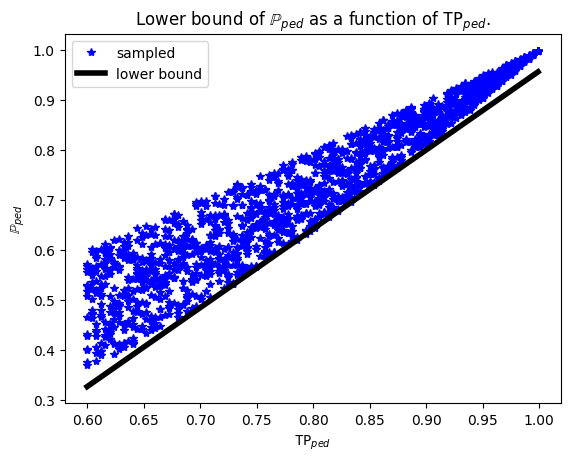

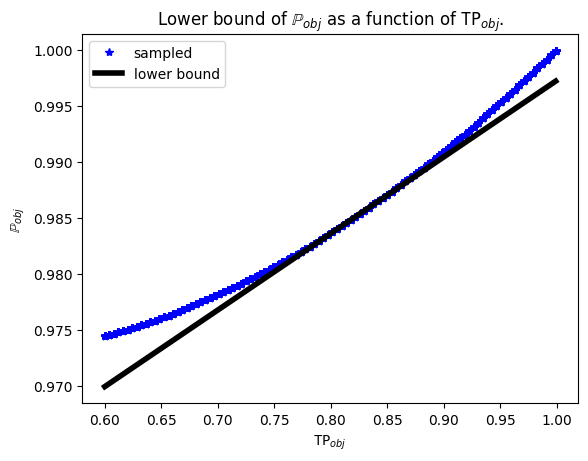

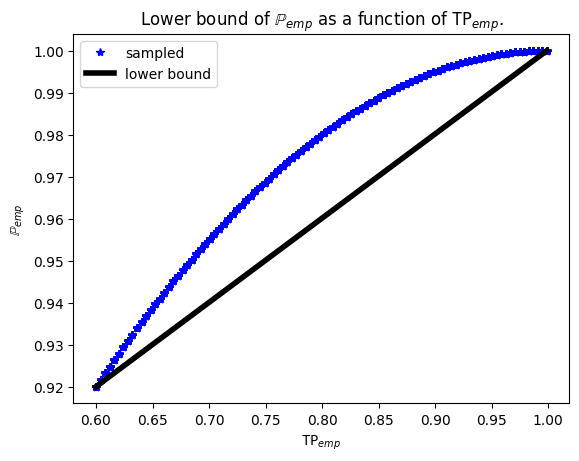

In [4]:
# Plotting Probabilities:
def plot_probabilities_bounds(points, tp_vals, ubounds, lbounds, true_env):
    fig, ax = plt.subplots()
    ax.tick_params(axis="both", which="major", labelsize=10)
    plt.plot(tp_vals, points, "b*", label="sampled")
    if ubounds != []:
        ub_m, ub_c = ubounds
        y_ub = ub_m * np.array(tp_vals) + ub_c
        plt.plot(tp_vals, y_ub, "r")

    lb_m, lb_c = lbounds
    y_lb = lb_m * np.array(tp_vals) + lb_c
    plt.plot(tp_vals, y_lb, "k", label="lower bound", linewidth=4)
    lb = min(tp_vals)
    ub = max(tp_vals)
    plt.legend(prop={"size": 10})

    plt.title("Lower bound of $\mathbb{P}_{" + true_env + "}$ as a function of $\mathtt{TP}_{" + true_env + "}$.")
    plt.ylabel("$\mathbb{P}_{" + true_env + "}$")
    plt.xlabel("$\mathtt{TP}_{" + true_env + "}$")


plot_probabilities_bounds(points_ped, tpped_vals, [], lbounds_ped, "ped")
plot_probabilities_bounds(points_obj, tpobj_vals, [], lbounds_obj, "obj")
plot_probabilities_bounds(points_emp, tpemp_vals, [], lbounds_emp, "emp")

Now, we construct the controller contracts for each object class using Polyhedral contracts and constructing it from string. We end up we three contracts --- $\mathcal{C}_{ped}$, $\mathcal{C}_{obj}$, and $\mathcal{C}_{emp}$, respectively for the $\textit{pedestrian}$, $\textit{object}$, and $\textit{background}$ classes. Each contract is constructed from the lower bounds evaluated for probabilities of satisfication of specifications as shown in the Figures above.

In [9]:
# First we construct each contract individually, and then merge the controller contract:
## Control contract for pedestrian class
def control_contract_ped(lbounds_ped):
    lb_m, lb_c = lbounds_ped
    tp = "tp_ped"
    P = "P_ped"
    input_vars = [f"{tp}"]
    output_vars = [f"{P}"]
    assumptions = [f"{tp} <= 1", f"-{tp} <= -0.6"]
    guarantees = [f"-{P} + "+str(lb_m)+ f"{tp} <= "+str(-1*lb_c)]
    Cped = PolyhedralContract.from_string(input_vars=input_vars, output_vars=output_vars, assumptions=assumptions, guarantees=guarantees)
    return Cped



def control_contract_obj(lbounds_obj):
    lb_m, lb_c = lbounds_obj

    tp = "tp_obj"
    P = "P_obj"
    input_vars = [f"{tp}"]
    output_vars = [f"{P}"]
    assumptions = [f"{tp} <= 1", f"-{tp} <= -0.3"]
    guarantees = [f"-{P} + "+str(lb_m)+ f"{tp} <= "+str(-1*lb_c)]
    Cobj = PolyhedralContract.from_string(input_vars=input_vars, output_vars=output_vars, assumptions=assumptions, guarantees=guarantees)
    return Cobj



def control_contract_emp(lbounds_emp):
    lb_m, lb_c = lbounds_emp

    tp = "tp_emp"
    P = "P_emp"
    input_vars = [f"{tp}"]
    output_vars = [f"{P}"]
    assumptions = [f"{tp} <= 1", f"-{tp} <= -0.6"]
    guarantees = [f"-{P} + "+str(lb_m)+ f"{tp} <= "+str(-1*lb_c)]
    Cemp = PolyhedralContract.from_string(input_vars=input_vars, output_vars=output_vars, assumptions=assumptions, guarantees=guarantees)
    return Cemp


Cped = control_contract_ped(lbounds_ped)
Cobj = control_contract_obj(lbounds_obj)
Cemp = control_contract_emp(lbounds_emp)

print("Controller Contract for pedestrian class:\n" + str(Cped) + "\n")
print("Controller Contract for object class:\n" + str(Cobj) + "\n")
print("Controller Contract for empty class:\n" + str(Cemp) + "\n")

Controller Contract for empty class:
InVars: [tp_emp]
OutVars:[P_emp]
A: [
  tp_emp <= 1.0
  -tp_emp <= -0.6
]
G: [
  -P_emp + 0.20049999999999998 tp_emp <= -0.7996999999999667
]



We use the merge operator to. Then, the control contracts are merged as follows to get the full contract describing the assumptions and guarantees of the controller:
$$\mathcal{C}_{control} = \mathcal{C}_{ped} \bullet \mathcal{C}_{obj} \bullet \mathcal{C}_{emp}$$

In [6]:
# Construct merger of contracts:
C_controller = Cped.merge(Cobj)
C_controller = C_controller.merge(Cemp)

print("Merged Controller Contract for all object classes:\n" + str(C_controller) + "\n")

Merged Controller Contract for all object classes:
InVars: [tp_ped, tp_obj, tp_emp]
OutVars:[P_ped, P_obj, P_emp]
A: [
  tp_ped <= 1.0
  -tp_ped <= -0.6
  tp_obj <= 1.0
  -tp_obj <= -0.3
  tp_emp <= 1.0
  -tp_emp <= -0.6
]
G: [
  -P_ped + 1.5801256015029996 tp_ped <= 0.6220524909016469
  -P_obj + 0.06834814849496082 tp_obj <= -0.9288940771532732
  -P_emp + 0.20049999999999998 tp_emp <= -0.7996999999999667
]



## Part 3: System Contract

The overall system level contract is return takes an input distance and returns the desired system-level probability is lower bounded by an affine function of distance. Thus, we encode the following is contract form:
$$\mathbb{P}_{ped}(s_0 \models \varphi_{ped}) \geq m_{ped}d + c_{ped},$$
$$\mathbb{P}_{obj}(s_0 \models \varphi_{obj}) \geq m_{obj}d + c_{obj},$$
$$\mathbb{P}_{emp}(s_0 \models \varphi_{emp}) \geq m_{emp}d + c_{emp},$$

where $m_{ped} = -0.099$, $c_{ped}=0.99$, $m_{obj} = -0.08$, $c_{obj}=0.8$, $m_{emp} = -0.09$, $c_{emp}=0.9$. For this case study example, these lower bounds were arbitrarily chosen.

In [12]:
## System contract: P >= 0.99
def system_contract_dist():
    a1, a2, a3 = 0.99, 0.8, 0.95
    d = "d"
    P_emp = "P_emp"
    P_obj = "P_obj"
    P_ped = "P_ped"
    input_vars = [d]
    output_vars = [P_ped, P_obj, P_emp]
    assumptions = [
        f"-{d} <= 0",
        f"{d} <= 10",
        ]

    guarantees = [
        f"-{P_ped} - 0.099{d} <= "+str(-a1),
        f"-{P_obj} - 0.08{d} <= "+str(-a2),
        f"-{P_emp} - 0.095{d} <= "+str(-a3),
        ]
    system_contract = PolyhedralContract.from_string(input_vars=input_vars, output_vars=output_vars, assumptions=assumptions, guarantees=guarantees)
    return system_contract

Csys_dist = system_contract_dist()
print("System Contract (distance bounds):\n" + str(Csys_dist) + "\n")

System Contract (distance bounds):
InVars: [d]
OutVars:[P_ped, P_obj, P_emp]
A: [
  -d <= 0.0
  d <= 10.0
]
G: [
  -P_ped - 0.099 d <= -0.99
  -P_obj - 0.08 d <= -0.8
  -P_emp - 0.095 d <= -0.95
]



## Part 4: Object Detection Contract found using quotient

Finally, to derive specifications on the object detection module, we derive lower bounds on the required $\textit{true positive rate}$ for each class. To do this, we take the quotient of the merged controller contract from the overall system contract, $$\mathcal{C}_{det} = \mathcal{C}_{sys}/\mathcal{C}_{control}$$

In [13]:
# Computing quotient contract:
C_det = Csys_dist.quotient(C_controller)
print("Quotient Contract with distance bounds on true positive rates:\n" + str(C_det) + "\n")

Quotient Contract with distance bounds on true positive rates:
InVars: [d]
OutVars:[tp_ped, tp_obj, tp_emp]
A: [
  -d <= 0.0
  d <= 10.0
]
G: [
  -0.099 d - 1.580125601503 tp_ped <= -1.6120524909016472
  tp_ped <= 1.0
  -tp_ped <= -0.6
  tp_obj <= 1.0
  -tp_obj <= -0.30000000000000004
  tp_emp <= 1.0
  -tp_emp <= -0.6
]



Let's see how contract $\mathcal{C}_{det}$ varies with distance to ego for the pedestrian specification.

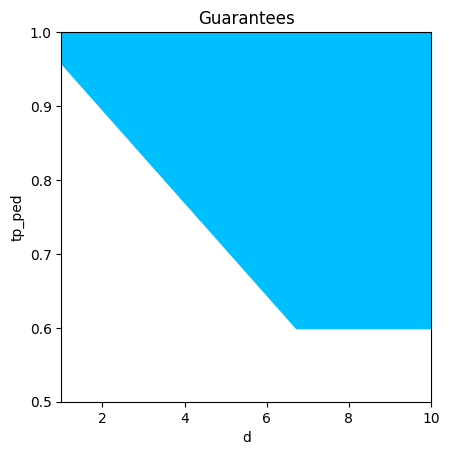

In [26]:
_= plots.plot_guarantees(C_det, Var('d'), Var('tp_ped'), var_values={Var('tp_obj'):0.4, Var('tp_emp'):0.7}, x_lims=[1,10],y_lims=[0.5,1])

## References

<a id="ref0"></a> __[Baier and Katoen. 2008](http://perso.ens-lyon.fr/quentin.guilmant/M1/Semestre2/SV/_principles_of_model_checking.pdf)__

Baier, Christel, and Joost-Pieter Katoen. 
**Principles of Model Checking.**

<a id="ref1"></a> __[Piterman et al. 2006](http://jtlv.ysaar.net/resources/publications/synth.pdf)__

Piterman, N., Pnueli, A., Sa’ar, Y.
**Synthesis of reactive (1) designs.**
In: International Workshop on Verification, Model Checking, and Abstract Interpretation.
pp. 364–380. Springer (2006)

<a id="ref2"></a> __[Wongpiromsarn et al. 2012](https://authors.library.caltech.edu/36081/)__

Wongpiromsarn, T., Topcu, U., Murray, R.M.
**Receding horizon temporal logic planning**
IEEE Transactions on Automatic Control 57(11), 2817–2830 (2012)

<a id="ref3"></a> __[Kress-Gazit et al. 2009](https://georgejpappas.org/papers/IEEE-LTL2009.pdf)__

Kress-Gazit, H., Fainekos, G.E., Pappas, G.J.: 
**Temporal-logic-based reactive mission and motion planning.**
IEEE Transactions on Robotics 25(6), 1370–1381 (2009) 26. 

<a id="ref4"></a> __[Lahijanian et al. 2009](https://www.bu.edu/anderssonlab/files/2013/08/IEEE_Conference_on_Decision_and_Control_2009_Lahijanian.pdf)__

Lahijanian, M., Andersson, S.B., Belta, C.
**A probabilistic approach for control of a stochastic system from LTL specifications.**
In: Proceedings of the 48h IEEE Conference on Decision and Control (CDC) held jointly with 2009 28th Chinese
Control Conference. pp. 2236–2241. IEEE (2009)

<a id="ref5"></a> __[Koyejo et al. 2015](https://proceedings.neurips.cc/paper/2015/file/85f007f8c50dd25f5a45fca73cad64bd-Paper.pdf)__

Koyejo, O., Natarajan, N., Ravikumar, P., Dhillon, I.S.
**Consistent multilabel classification.**
In: NeurIPS. vol. 29, pp. 3321–3329 (2015)


<a id="ref6"></a> __[Kloetzer et al. 2008](https://sites.bu.edu/hyness/files/2014/05/TAC08_LTL_Contr.pdf)__

Kloetzer, M., Belta, C.
**A fully automated framework for control of linear systems from temporal logic specifications.**
IEEE Transactions on Automatic Control 53(1),
287–297 (2008)

<a id="ref7"></a> __[Geron et al. 2019](https://github.com/ageron/handson-ml2)__

Géron, A.: Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow:
Concepts, Tools, and Techniques to Build Intelligent Systems. O’Reilly Media
(2019)

<a id="ref8"></a> __[BWM 2021](https://ieeexplore.ieee.org/document/9683611)__

Badithela, A., Wongpiromsarn, T., Murray, R.M.: Leveraging classification metrics
for quantitative system-level analysis with temporal logic specifications. In: 2021
60th IEEE Conference on Decision and Control (CDC). pp. 564–571. IEEE (2021)


<a id="ref9"></a> __[BWM 2022](https://arxiv.org/pdf/2210.10298)__

Badithela, A., Wongpiromsarn, T., Murray, R.M.: Evaluation metrics for object
detection for autonomous systems. arXiv preprint arXiv:2210.10298 (2022)

<a id="ref10"></a> __[Narasimhan et al. 2015](http://proceedings.mlr.press/v37/narasimhanb15.pdf)__
Narasimhan, H., Ramaswamy, H., Saha, A., Agarwal, S.

**Consistent multiclass algorithms for complex performance measures.**
In: International Conference on
Machine Learning. pp. 2398–2407. PMLR (2015)

<a id="ref11"></a> __[Topan et al. 2022](https://arxiv.org/abs/2206.12471)__

Topan, S., Leung, K., Chen, Y., Tupekar, P., Schmerling, E., Nilsson, J., Cox, M.,
Pavone, M.

**Interaction-dynamics-aware perception zones for obstacle detection safety evaluation.**

In: 2022 IEEE Intelligent Vehicles Symposium (IV). pp. 1201–1210. IEEE (2022)

<a id="ref12"></a> __[Wang et al. 2019](https://arxiv.org/pdf/1908.09057)__

Wang, X., Li, R., Yan, B., Koyejo, O.
**Consistent classification with generalized metrics.**
arXiv preprint arXiv:1908.09057 (2019)
